# ベースライン作成から特徴量エンジニアリングに進む
特徴量エンジニアリングの進め方。
特徴量エンジニアリングは一気に行うのではなく、欠損値の補完、説明変数を生成して追加、バリエーション設計の変更などなどの1つ1つの処理が
モデル精度に与える影響を検証しながら進める。
新しい処理の結果、目指す評価係数が改善されれば採用、悪化すれば不採用にして試行錯誤を繰り返す。
今回はベースラインのコードの以下に変更を加える - 
- データ前処理
- 
- 

今回はタイタニック予測のベースライン作成を行う。
タイタニック予測のは分類問題なので、評価指標はPrecision、Recall、Accuracy、AUC（適合率、再現率、正解率、予測値の順序性）の4つとなる。

# インポート

In [22]:
import numpy as np
import pandas as pd
import os
import pickle
import gc

# 分布確認に使う
# import pandas_profiling as pdp
# 可視化
import matplotlib.pyplot as plt
# 前処理、特徴量作成 - sklearnを使う
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
# モデリング・精度と評価指標
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
#LGBM
import lightgbm as lgb

#どうでもいい警告は無視する設定に
import warnings
warnings.filterwarnings("ignore")

PydanticImportError: `BaseSettings` has been moved to the `pydantic-settings` package. See https://docs.pydantic.dev/2.1.1/migration/#basesettings-has-moved-to-pydantic-settings for more details.

For further information visit https://errors.pydantic.dev/2.1.1/u/import-error

In [3]:
# NOTE matplotでの日本語文字化けを解消
#pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

In [4]:
df_train = pd.read_csv("titanic_datasets/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## データ確認
データ数、カラム数、データ型を確認する

In [5]:
print("データ形状：")
print(df_train.shape)

print("データ数：")
print(len(df_train))

print("データのコラム数")
print(len(df_train.columns))

データ形状：
(891, 12)
データ数：
891
データのコラム数
12


In [6]:
print("データ型一覧")
df_train.info()

データ型一覧
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# データ前処理
量的・質的変数や度数の一括確認

In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [16]:
#質的変数
df_train.describe(exclude="number").T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


In [17]:
#1つの量的変数の要約統計量を確認する
df_train[["Fare"]].agg(["mean","std","min","max"]).T

,mean,std,min,max
Fare,32.204208,49.693429,0.0,512.3292


In [18]:
#テーブル全体の要約統計量
df_train.agg(["mean","std","min","max"]).T

,mean,std,min,max
PassengerId,446.0,257.353842,1.0,891.0
Survived,0.383838,0.486592,0.0,1.0
Pclass,2.308642,0.836071,1.0,3.0
Name,NaN,NaN,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
Sex,NaN,NaN,female,male
Age,29.699118,14.526497,0.42,80.0
SibSp,0.523008,1.102743,0.0,8.0
Parch,0.381594,0.806057,0.0,6.0
Ticket,NaN,NaN,110152,WE/P 5735
Fare,32.204208,49.693429,0.0,512.3292


In [21]:
pdp.profileReport(df_train)

NameError: name 'pdp' is not defined

## 欠損値の補完
欠損している値に本来の値に近いものを当てはめるとより精度が向上する

In [23]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Age、Cabin、Embarkedに欠損があるのでその補完を目指す

# ベースライン作成
まず量的データのみを使ったベースラインモデルを作成する

In [8]:
X_train, y_train, id_train = df_train[["Pclass","Age","SibSp","Parch","Fare"]], df_train[["Survived"]], df_train[["PassengerId"]]
X_train.head()

,Pclass,Age,SibSp,Parch,Fare
0,3,22.0,1,0,7.2500
1,1,38.0,1,0,71.2833
2,3,26.0,0,0,7.9250
3,1,35.0,1,0,53.1000
4,3,35.0,0,0,8.0500


In [9]:
y_train.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [10]:
# データ形状が問題ないか判定
print(X_train.shape)
print(y_train.shape)
print(id_train.shape)

(891, 5)
(891, 1)
(891, 1)


## ホールドアウト検証
学習用・テスト用の分割を1通り決める

In [11]:
# ホールドアウト検証 - 学習用・テスト用の分割を1通り決める
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print("学習用・訓練用データの形状：")
print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)
    
# データのラベルに偏りがないか表示
y_train_mean = y_train["Survived"].mean()
y_tr_mean = y_tr["Survived"].mean()
y_va_mean = y_va["Survived"].mean()
    
print("全体の生存者割合：")
print(y_train_mean)
print("学習用データの生存者割合：")
print(y_tr_mean)
print("検証用データの生存者割合：")
print(y_va_mean)

学習用・訓練用データの形状：
(712, 5)
(712, 1)
(179, 5)
(179, 1)
全体の生存者割合：
0.3838383838383838
学習用データの生存者割合：
0.38342696629213485
検証用データの生存者割合：
0.3854748603351955


## 交差検証
学習用・テスト用の分割をテスト用の割合の逆数分だけ繰り返す。偏ったデータによる過学習を防止できる利点があるが、その分学習に時間がかかる。

In [12]:
"""
n_splits = 5
cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X_train, y_train))

for nfold in np.arrange(n_splits):
    # 分割分だけデータセットを作成する
    print("-"*20, nfold, "-"*20)
    
    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
    X_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]
    X_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]
    print(X_tr.shape, y_tr.shape)
    print(X_va.shape, y_va.shape)
    
    # データのラベルに偏りがないか表示
    y_train_mean = y_train["Survived"].mean()
    y_tr_mean = y_tr["Survived"].mean()
    y_va_mean = y_va["Survived"].mean()
    
    print("全体の生存者割合：")
    print(y_train_mean)
    print("学習用フォールドの生存者割合：")
    print(y_tr_mean)
    print("検証用フォールドの生存者割合：")
    print(y_va_mean)
    
    #機械学習はこの段階で開始
"""

'\nn_splits = 5\ncv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X_train, y_train))\n\nfor nfold in np.arrange(n_splits):\n    # 分割分だけデータセットを作成する\n    print("-"*20, nfold, "-"*20)\n    \n    idx_tr, idx_va = cv[nfold][0], cv[nfold][1]\n    X_tr, y_tr = X_train.loc[idx_tr, :], y_train.loc[idx_tr, :]\n    X_va, y_va = X_train.loc[idx_va, :], y_train.loc[idx_va, :]\n    print(X_tr.shape, y_tr.shape)\n    print(X_va.shape, y_va.shape)\n    \n    # データのラベルに偏りがないか表示\n    y_train_mean = y_train["Survived"].mean()\n    y_tr_mean = y_tr["Survived"].mean()\n    y_va_mean = y_va["Survived"].mean()\n    \n    print("全体の生存者割合：")\n    print(y_train_mean)\n    print("学習用フォールドの生存者割合：")\n    print(y_tr_mean)\n    print("検証用フォールドの生存者割合：")\n    print(y_va_mean)\n    \n    #機械学習はこの段階で開始\n'

# モデル学習
LightGBMでベースラインモデルを作成。テーブルデータを使った教師あり学習では大抵コレを使う。
- モデルの精度がそれなりに高い
- 処理が高速
- カテゴリ変数を自動で前処理してくれる
- 欠損値を自動で前処理してくれる
- 異常値の影響を受けにくい

In [13]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)
    
# データのラベルに偏りがないか表示
y_train_mean = y_train["Survived"].mean()
y_tr_mean = y_tr["Survived"].mean()
y_va_mean = y_va["Survived"].mean()
    
print("全体の生存者割合：")
print(y_train_mean)
print("学習用データの生存者割合：")
print(y_tr_mean)
print("検証用データの生存者割合：")
print(y_va_mean)

(712, 5)
(712, 1)
(179, 5)
(179, 1)
全体の生存者割合：
0.3838383838383838
学習用データの生存者割合：
0.38342696629213485
検証用データの生存者割合：
0.3854748603351955


In [14]:
# LGBMのパラメータ
params = {"boosting_type":"gbdt",
          "objective":"binary",
          "metric":"auc",
          "learning_rate":0.1,
          "num_leaves":16,
          "n_estimators":1000,
          "random_state":123,
          "importance_type":"gain",
          "early_stopping_round":100,
          "verbose":10
          }

# LGBMのモデル
model = lgb.LGBMClassifier(**params)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_va, y_va)])

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.725421
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.293539
[LightGBM] [Debug] init for col-wise cost 0.000698 seconds, init for row-wise cost 0.000292 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Debug] Trained a tree with leaves = 16 and depth = 7
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug

LGBMClassifier(early_stopping_round=100, importance_type='gain', metric='auc',
               n_estimators=1000, num_leaves=16, objective='binary',
               random_state=123, verbose=10)

次にモデルを実際に動かして学習精度・検証精度を出します。検証精度は一応ランダムな予測以上の値が出ていますが、AUC率よりも低くまだまだ改善の余地があります。

In [ ]:
# AUC値に加え精度を算出する
y_tr_pred = model.predict(X_tr)
y_va_pred = model.predict(X_va)

metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print("モデル精度:")
print("学習精度")
print(metric_tr)
print("検証精度")
print(metric_va)

モデル精度:
学習精度
0.9058988764044944
検証精度
0.664804469273743


In [ ]:
# モデル学習 - LazyPredict
次に、LazyPredictでベースラインモデルを作成します。

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

reg = LazyClassifier(ignore_warnings=True, random_state=1121, verbose=False,predictions=True)
models, predictions = reg.fit(X_tr, X_va, y_tr, y_va) 

print("モデルの精度・評価指標：")
display(models)
print("テストデータの予測値：")
display(predictions)

100%|██████████| 29/29 [00:01<00:00, 15.41it/s]

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.73,0.72,0.72,0.73,0.02
SVC,0.74,0.71,0.71,0.74,0.08
PassiveAggressiveClassifier,0.71,0.69,0.69,0.71,0.03
QuadraticDiscriminantAnalysis,0.72,0.68,0.68,0.71,0.03
BernoulliNB,0.70,0.67,0.67,0.69,0.07
LinearDiscriminantAnalysis,0.71,0.67,0.67,0.70,0.07
RidgeClassifierCV,0.71,0.67,0.67,0.70,0.02
RidgeClassifier,0.71,0.67,0.67,0.70,0.05
GaussianNB,0.70,0.67,0.67,0.70,0.03


テストデータの予測値：


,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,...,PassiveAggressiveClassifier,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,1,1,0,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,1,1,0,...,1,0,1,1,1,1,1,1,0,1
4,0,1,0,0,1,0,0,1,0,1,...,0,1,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0,0,1,1,0,0,1,0,1,0,...,1,0,1,0,1,1,0,0,1,0
175,1,0,0,1,1,0,1,1,0,0,...,0,1,0,1,1,1,0,0,1,1
176,0,1,0,0,1,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,0
177,0,0,0,1,0,0,0,0,1,0,...,1,0,1,0,1,1,0,0,0,0


# 混合行列

In [ ]:
y_pred=model.predict(X_va)
y_pred[:5]

array([0, 1, 0, 0, 0], dtype=int64)

混合行列：
[[78 28]
 [32 41]]


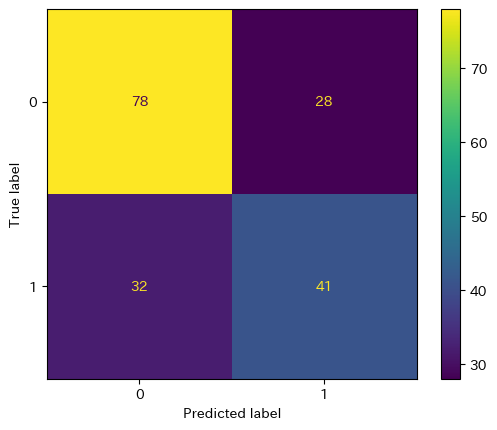

In [ ]:
# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
disp.plot()
plt.show()

In [ ]:
# 生存できなかった人を正しく予測する率の方が、生存できなかった人を正しく予測する確率よりも高い。(適合率＞再現率)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

"""
適合率は予測されたラベルのうち、どれだけが正解だったか
再現率は正解のラベルのうち、どれだけそのラベルを予測できたか

一般的に誤検出を少なくしたい場合には適合率。取りこぼしを少なくしたい場合には再現率を重視します。

医療等に機械学習を活用する等「取りこぼしが多いと命に関わるような重大な問題に繋がる」といったような場合には、再現率を評価指標に使用するのが適切です。
"""

#適合率 - TP+TN / (TP+FP+TN+FN) - 単純な正答率
print("正答率")
print(accuracy_score(y_pred, y_va))

#適合率 - TP / (TP+FP) - 予測されたラベルに対する実際に正解となるサンプル
print("適合率")
print(precision_score(y_pred, y_va))

#再現率 - TP / (TP+FN) - 本来正しく予測した場合に対し実際に正解となるサンプル
print("再現率")
print(recall_score(y_pred, y_va))

print("F値")
print(f1_score(y_pred, y_va))

正答率
0.664804469273743
適合率
0.5942028985507246
再現率
0.5616438356164384
F値
0.5774647887323944
